In [1]:
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:

import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

images_path = "/content/gdrive/MyDrive/floorplangen"
while not os.path.exists(str(images_path)):
  print('The images_path specified does not exist, use the colab file explorer to copy the path :')
  images_path=input("")
save_path = images_path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


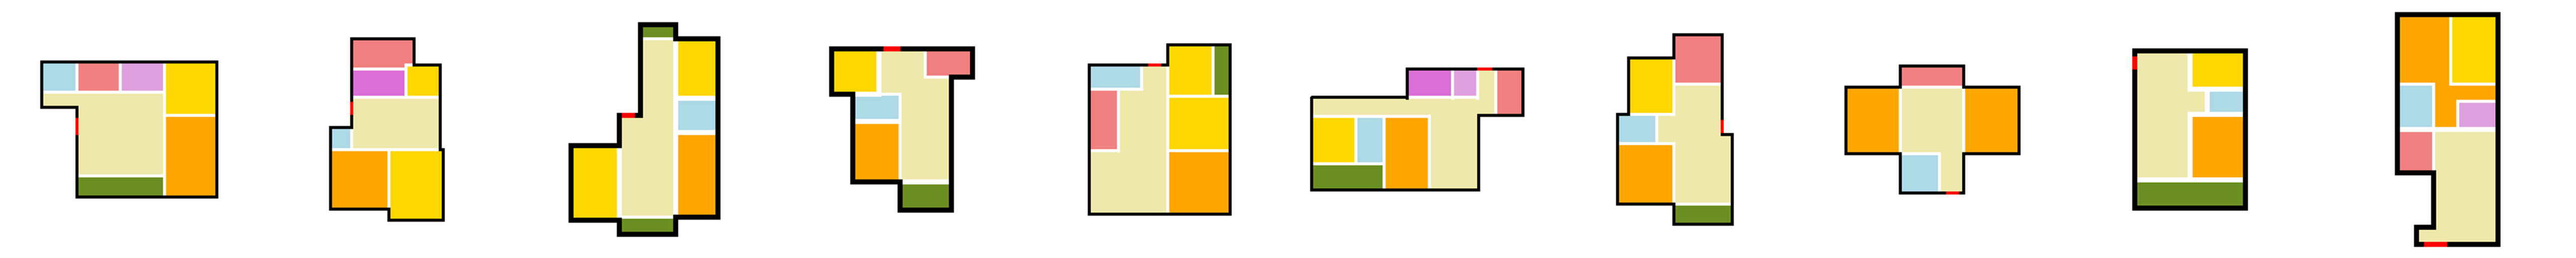

In [5]:
images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [6]:
# what_to_teach = "object"
placeholder_token = "<floor-plan>"
initializer_token = "plan"

In [7]:
prompts = [
  "{} of a house with white walls, 1 living room pale goldenrod, 1 common room gold, 1 master room orange, 1 kitchen light coral, 1 bath room light blue, 1 storage room plum",
  "{} of a house with white walls, 1 master room orange, 2 common room gold, 1 living room pale goldenrod, 1 bath room light blue, 1 dining room orchid, 1 kitchen light coral",
  "{} of a house with white walls, 2 common room gold, 2 balcony olive drab, 1 living room pale goldenrod, 1 bath room light blue, 1 master room orange",
  "{} of a house with white walls, 1 balcony olive drab, 1 living room pale goldenrod, 1 master room orange, 1 bath room light blue, 1 kitchen light coral, 1 common room gold",
  "{} of a house with white walls, 1 living room pale goldenrod, 1 kitchen light coral, 1 bath room light blue, 2 common room gold, 1 balcony olive drab, 1 master room orange",
  "{} of a house with white walls, 1 master room orange, 1 balcony olive drab, 1 bath room light blue, 1 common room gold,  1 living room pale goldenrod, 1 storage room plum, 1 dining room orchid, 1 kitchen light coral",
  "{} of a house with white walls, 1 balcony olive drab, 1 living room pale goldenrod, 1 master room orange, 1 bath room light blue, 1 common room gold, 1 kitchen light coral",
  "{} of a house with white walls, 1 bath room light blue, 1 living room pale goldenrod, 2 master room orange, 1 kitchen light coral",
  "{} of a house with white walls, 1 common room gold, 1 bath room light blue, 1 master room orange, 1 balcony olive drab, 1 living room pale goldenrod",
  "{} of a house with white walls, 1 living room pale goldenrod, 1 kitchen light coral, 1 storage room plum, 1 master room orange, 1 bath room light blue, 1 common room gold"
]

In [8]:

class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        # learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        # self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        # self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.templates = prompts
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        # text = random.choice(self.templates).format(placeholder_string)
        text = self.templates[i % self.num_images].format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [9]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [10]:
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [11]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [12]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

In [13]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [14]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [15]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      # learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

<ipython-input-15-095fc61ccdaa>:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,
<ipython-input-8-7bd01d8cc981>:33: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,


In [16]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [17]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

In [18]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

In [19]:
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [23]:
torch.backends.cuda.enable_flash_sdp(False)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2000 [00:00<?, ?it/s]